<hr style="border:2px solid gray">

##### Author  : SIVA VIKNESH 
##### Email   : siva.viknesh@sci.utah.edu / sivaviknesh14@gmail.com 
##### Address : SCI INSTITUTE, UNIVERSITY OF UTAH, SALT LAKE CITY, UTAH, USA 
<hr style="border:2px solid gray">

In [1]:
import os
import torch
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as plticker
from mpl_toolkits.mplot3d import Axes3D
from scipy import integrate
rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]

from itertools import combinations
np.set_printoptions(threshold=np.inf)
np.set_printoptions(suppress=True, precision=15)

Periodically-underdamped oscillator:  <br>
Paper: Harmonic Oscillators with Nonlinear Damping
$$
\begin{aligned}
\dot{x} & = y \\
\dot{y} & = -ax + b y\hspace{1.5mm}\text{cos}(cx) \\
\end{aligned}
$$

Parameters: \\(a\\), \\(b\\), \\(c\\), \\(d\\)

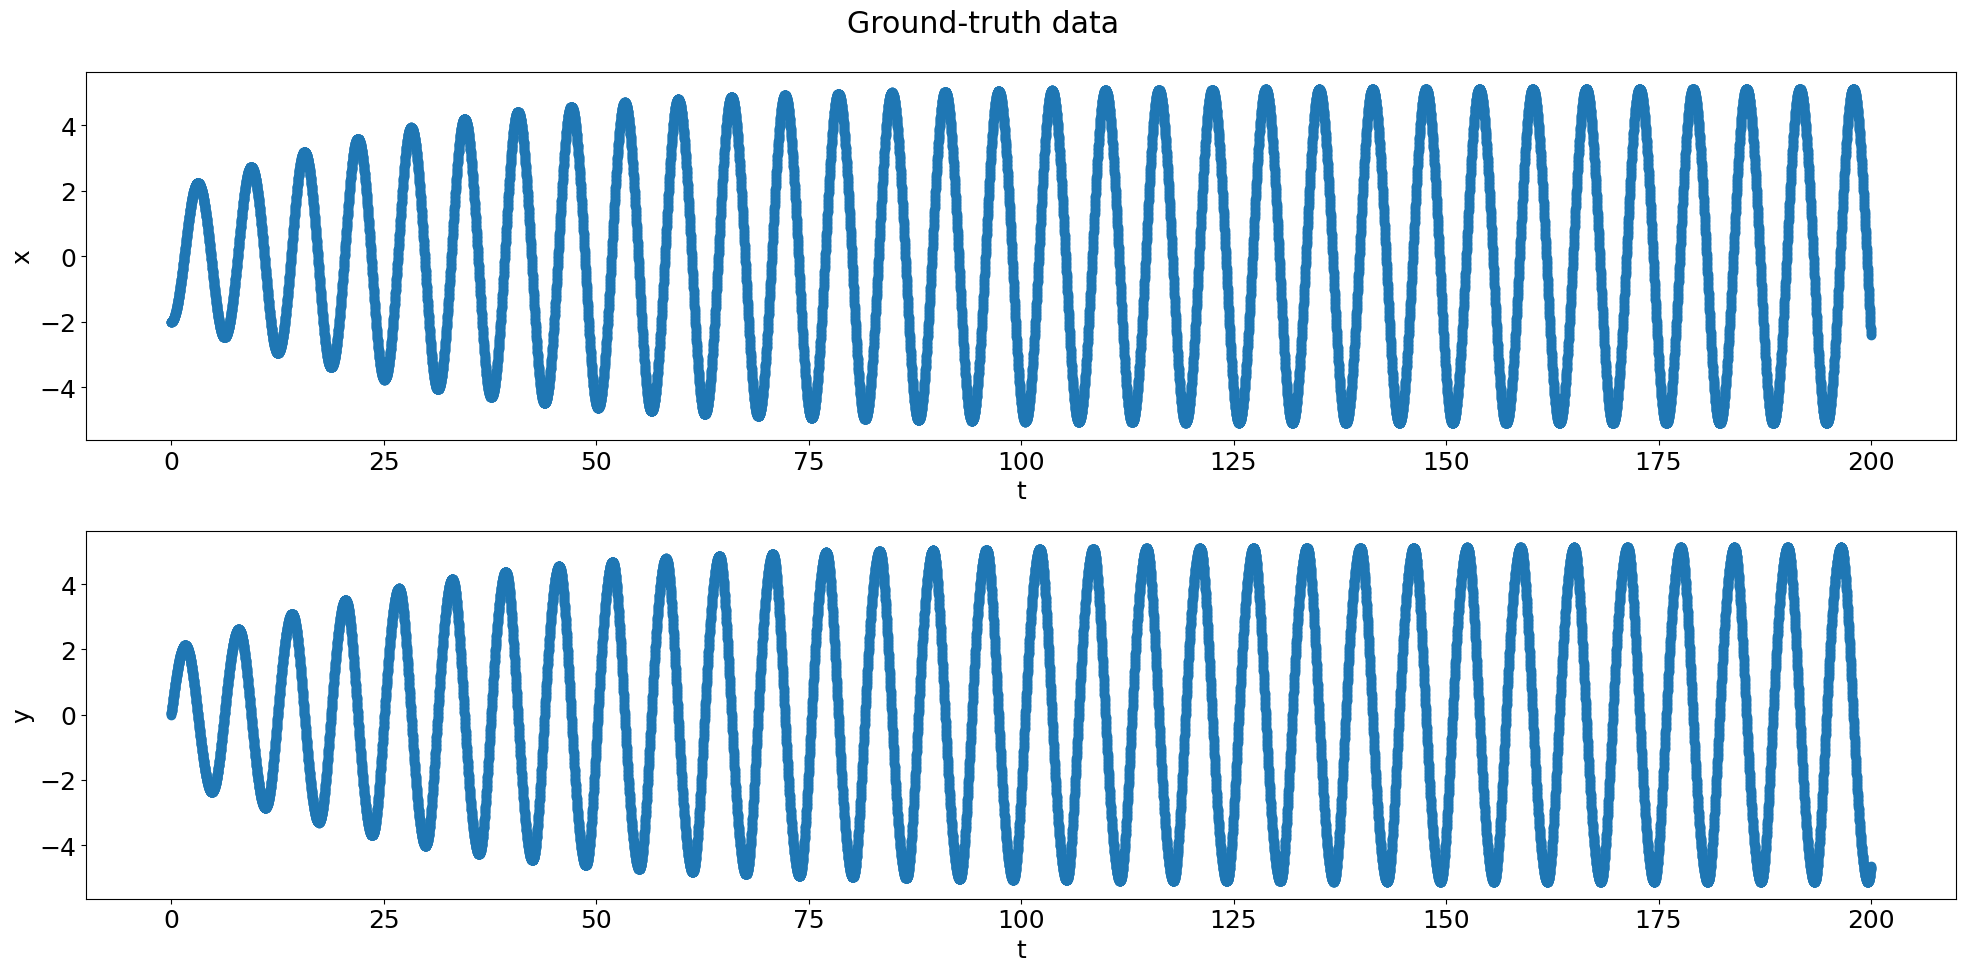

In [2]:
dt = 0.01
T = 200
t = np.arange(0,T+dt,dt)
a = -1.0
b =  0.1
c =  0.750

def oscillator_deriv(x_y, t0, a = a, b = b, c = c):
    x, y = x_y
    return [y, a*x +(b*y)*(np.cos(c*x))]

np.random.seed(123)
x0 = (-2, 0)
x_t = integrate.odeint(oscillator_deriv, x0, t, rtol=10**(-12),atol=10**(-12)*np.ones_like(x0))
x, y = x_t.T

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize =(20, 10))
fig.suptitle('Ground-truth data')

ax[0].plot(t, x, '-o') 
#ax[0].set_title('$x$')
ax[0].set(xlabel="t",ylabel="x")

ax[1].plot(t, y, '-o') 
#ax[1].set_title('$y$')
ax[1].set(xlabel="t",ylabel="y")

fig.tight_layout()
plt.show()


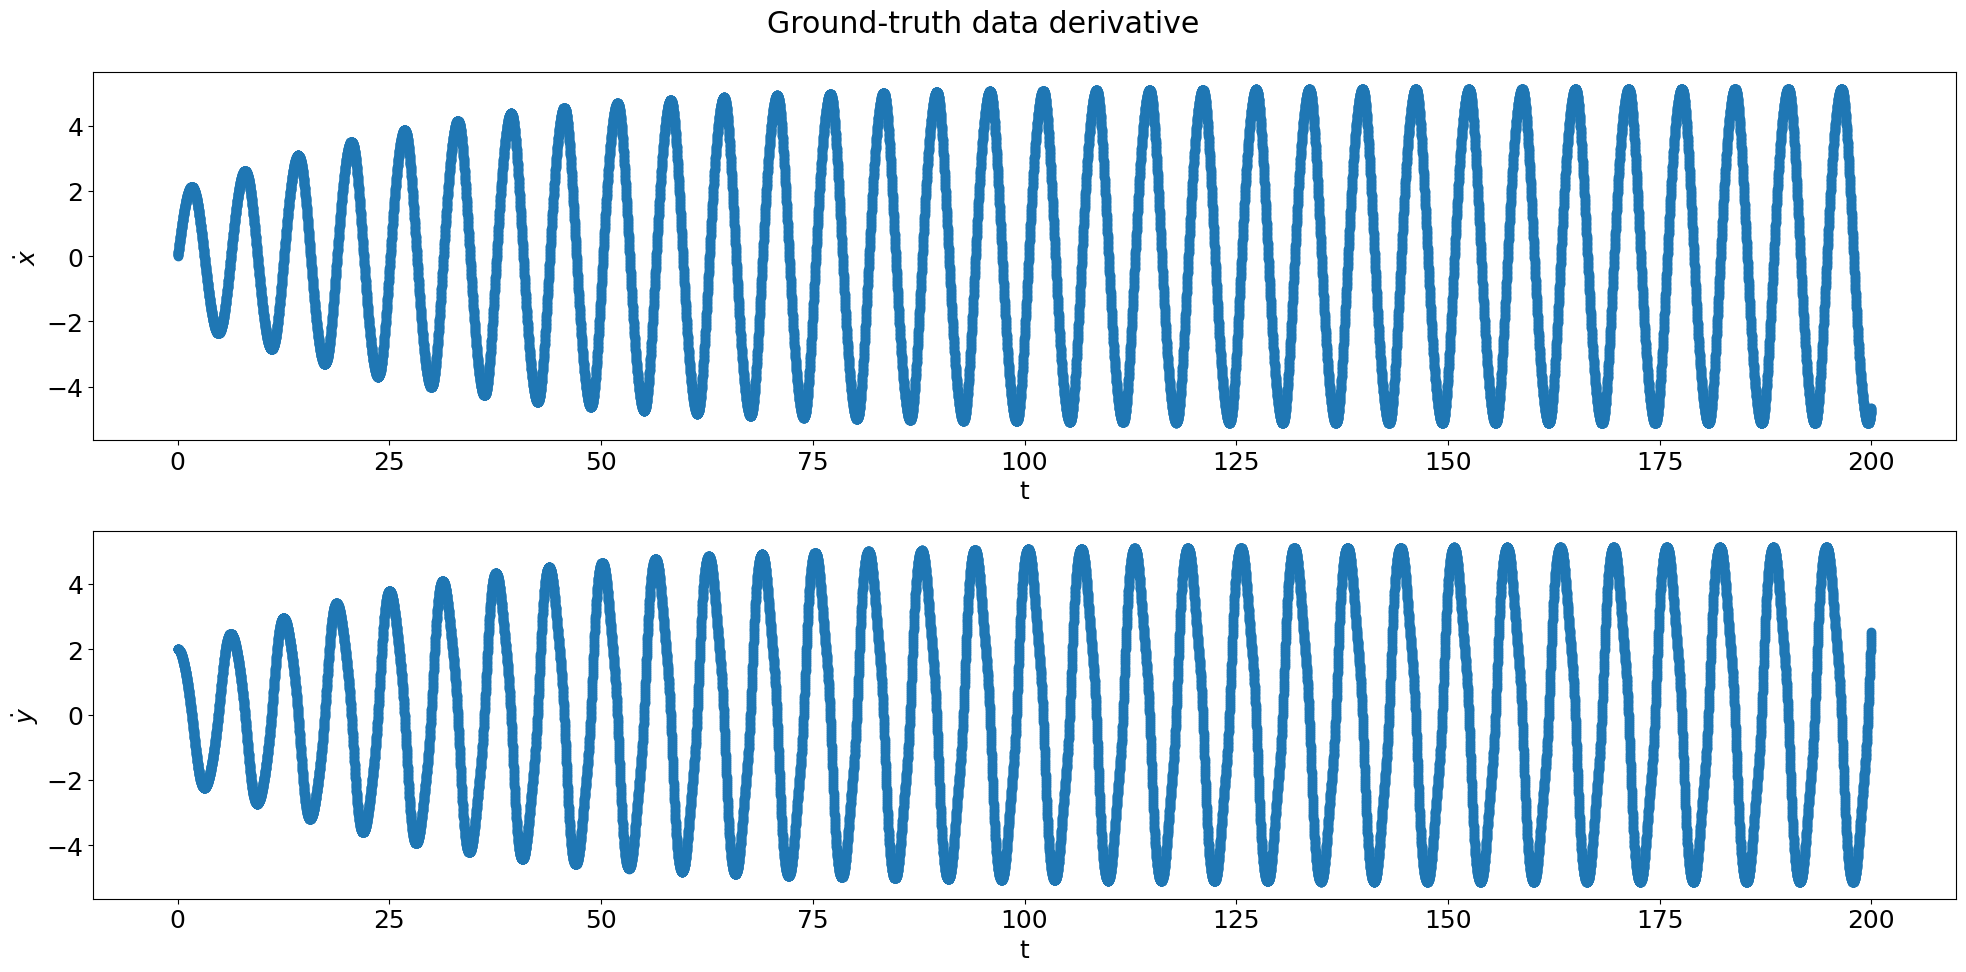

In [3]:
def DERIVATIVE(x, y, a, b, c):
    dxdt = y
    dydt = a*x + b*y*np.cos(c*x)    
    return np.vstack((dxdt, dydt)).T

A1A2_time_deriv = DERIVATIVE (x, y, a, b, c)

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize =(20, 10))
fig.suptitle('Ground-truth data derivative')

ax[0].plot(t, A1A2_time_deriv[:, 0], '-o')
ax[0].set(xlabel="t",ylabel="$\dot{x}$")

ax[1].plot(t, A1A2_time_deriv[:, 1], '-o') 
ax[1].set(xlabel="t",ylabel="$\dot{y}$")

fig.tight_layout()
plt.show()

In [4]:
## SINDy Function Definitions
def poolData(yin,nVars,polyorder):
    n = yin.shape[0]
    yout = np.zeros((n,1))

    # poly order 0
    yout[:,0] = np.ones(n)

    # poly order 1
    for i in range(nVars):
        yout = np.append(yout,yin[:,i].reshape((yin.shape[0],1)),axis=1)

    # poly order 2
    if polyorder >= 2:
        for i in range(nVars):
            for j in range(i,nVars):
                yout = np.append(yout,(yin[:,i]*yin[:,j]).reshape((yin.shape[0],1)),axis=1)

    # poly order 3
    if polyorder >= 3:
        for i in range(nVars):
            for j in range(i,nVars):
                for k in range(j,nVars):
                    yout = np.append(yout,(yin[:,i]*yin[:,j]*yin[:,k]).reshape((yin.shape[0],1)),axis=1)

    return yout

def sparsifyDynamics(Theta,dXdt,lamb,n): #Solves SINDy's L1 regularized convex optimization problem
    Xi = np.linalg.lstsq(Theta,dXdt,rcond=None)[0] # Initial guess: Least-squares

    for k in range(10):
        smallinds = np.abs(Xi) < lamb # Find small coefficients
        Xi[smallinds] = 0                          # and threshold
        for ind in range(n):                       # n is state dimension
            biginds = smallinds[:,ind] == 0
            # Regress dynamics onto remaining terms to find sparse Xi
            Xi[biginds,ind] = np.linalg.lstsq(Theta[:,biginds],dXdt[:,ind],rcond=None)[0]

    return Xi

In [5]:
N_frequency = 4
modes = np.linspace (0.25, 1.0, N_frequency) # Frequencies
#modes = np.array ([0.1, 0.75, 2.0])
print (modes)
# POLYNOMIAL TERMS
poly_candidate  = poolData(x_t, 2, 3)

poly_candidate = poly_candidate [:, 1:] # IGNORING THE CONSTANT - FIRST COLUMN !!!

# FOURIER TERMS
Nsize = poly_candidate.shape[1] * N_frequency
sine_candidate = np.zeros((poly_candidate.shape[0], Nsize))
cos_candidate  = np.zeros((poly_candidate.shape[0], Nsize))

k = 0
for i in range (poly_candidate.shape[1]):
    for  j in range (N_frequency):
        sine_candidate [:, k] = np.sin(poly_candidate [:, i] * modes [j])
        cos_candidate  [:, k] = np.cos(poly_candidate [:, i] * modes [j])
        k += 1

# FOURIER TERMS * POLYNOMIAL TERMS
xsine_candidate = np.zeros((poly_candidate.shape[0], Nsize*poly_candidate.shape[1]))
xcos_candidate  = np.zeros((poly_candidate.shape[0], Nsize*poly_candidate.shape[1]))

k = 0
for i in range (Nsize):
    for  j in range (poly_candidate.shape[1]):
        xsine_candidate [:, k] = sine_candidate [:, i] * poly_candidate [:, j]
        xcos_candidate  [:, k] = cos_candidate  [:, i] * poly_candidate [:, j]
        k += 1

All_candidates       = np.hstack((poly_candidate, sine_candidate, cos_candidate, xsine_candidate, xcos_candidate))


[0.25 0.5  0.75 1.  ]


**Considering all the candidates in the optimization**

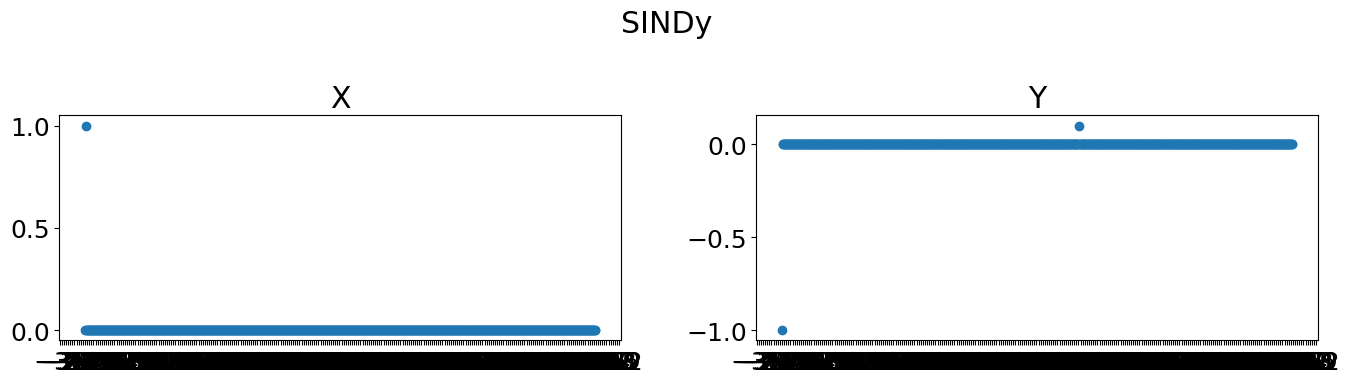

[[1.]]
[[-1.   0.1]]
(array([1]),)
(array([  0, 424]),)


In [6]:
lamb = 0.01 # sparsification knob lambda
coeff_matrix = sparsifyDynamics(All_candidates, A1A2_time_deriv, lamb, 2)
#print(coeff_matrix)
threshold = 0.0005
#****************************************************************************#
loc = plticker.MultipleLocator(base=3) # this locator puts ticks at regular intervals
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize =(14, 4))
fig.suptitle('SINDy')

ax[0].plot(coeff_matrix [:, 0], 'o') 
ax[0].set_title('X')
ax[0].xaxis.set_major_locator(loc)

ax[1].plot(coeff_matrix [:, 1], 'o') 
ax[1].set_title('Y')
ax[1].xaxis.set_major_locator(loc)

fig.subplots_adjust(top=0.8)
fig.tight_layout()
plt.show()

print(coeff_matrix[np.nonzero(coeff_matrix[:, 0]), 0])
print(coeff_matrix[np.nonzero(coeff_matrix[:, 1]), 1])
print(np.nonzero(coeff_matrix[:, 0]))
print(np.nonzero(coeff_matrix[:, 1]))